In [1]:
import shutup

shutup.please()

import pandas as pd
import numpy as np
import statistics

from datetime import datetime
import os, os.path, pickle, sys

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter

sys.path.append("/Users/hn/Documents/00_GitHub/Rangeland/Python_Codes/")
import rangeland_core as rc

In [2]:
data_dir_base = "/Users/hn/Documents/01_research_data/RangeLand/Data/"
census_population_dir = data_dir_base + "census/"
# Shannon_data_dir = data_dir_base + "Shannon_Data/"
# USDA_data_dir = data_dir_base + "/NASS_downloads/"
param_dir = data_dir_base + "parameters/"
Min_data_base = data_dir_base + "Min_Data/"
reOrganized_dir = data_dir_base + "reOrganized/"

plots_dir = data_dir_base + "plots/"

In [3]:
SoI = ["Alabama", "Arizona", "Arkansas", "California",
       "Colorado", "Florida", "Georgia", "Idaho", "Illinois", "Iowa",
       "Kansas", "Kentucky", "Louisiana", "Mississippi",
       "Missouri", "Montana", "Nebraska", "Nevada",
       "New Mexico", "North Dakota", "Oklahoma", "Oregon", "South Dakota",
       "Tennessee", "Texas", "Utah", "Virginia", "Washington", "Wyoming"]

abb_dict = pd.read_pickle(param_dir + "state_abbreviations.sav")
SoI_abb = []
for x in SoI:
    SoI_abb = SoI_abb + [abb_dict["full_2_abb"][x]]

In [4]:
d = {"state": abb_dict["abb_2_full"].keys(),
    "full_state": abb_dict["abb_2_full"].values()}

# creating a Dataframe object
state_abbrFull_df = pd.DataFrame(d)
state_abbrFull_df = state_abbrFull_df[state_abbrFull_df.full_state.isin(SoI)]
state_abbrFull_df.reset_index(drop=True, inplace=True)
state_abbrFull_df.head(2)

,state,full_state
0,AL,Alabama
1,AR,Arkansas


In [5]:
county_id_name_fips = pd.read_csv(Min_data_base + "county_id_name_fips.csv")
county_id_name_fips.rename(columns=lambda x: x.lower().replace(" ", "_"), inplace=True)

county_id_name_fips.sort_values(by=["state", "county"], inplace=True)
county_id_name_fips.rename(columns={"county": "county_fips"}, inplace=True)

county_id_name_fips = rc.correct_Mins_FIPS(df=county_id_name_fips, col_="county_fips")
county_id_name_fips.reset_index(drop=True, inplace=True)
county_id_name_fips["state_fip"] = county_id_name_fips.county_fips.str.slice(0, 2)
county_id_name_fips.head(2)

,county_fips,county_name,fips,state,state_fip
0,02013,Aleutians East Borough,2013,AK,02
1,02016,Aleutians West Census Area,2016,AK,02


In [6]:
state_fips_df = county_id_name_fips.copy()
state_fips_df = state_fips_df[["state", "state_fip"]]
state_fips_df.drop_duplicates(inplace=True)
state_fips_df = state_fips_df[state_fips_df.state.isin(SoI_abb)]
state_fips_df.reset_index(drop=True, inplace=True)
state_fips_df.head(2)

,state,state_fip
0,AL,01
1,AR,05


In [7]:
annual_invent = pd.read_pickle(reOrganized_dir + "Shannon_Beef_Cows_fromCATINV_tall.sav")
annual_invent = annual_invent["CATINV_annual_tall"]
annual_invent.head(2)

chosen_states = ["CO", "UT", "NM",  "OK", "TX"]
annual_invent_5states = annual_invent[annual_invent.state.isin(chosen_states)].copy()
annual_invent_5states.reset_index(drop=True, inplace=True)
annual_invent_5states.head(2)

,state,year,inventory,state_fip
0,CO,1920,465000.0,08
1,CO,1921,468000.0,08


In [8]:
# Rangeland area and Total area:
state_RA = pd.read_pickle(reOrganized_dir + "state_RA_area.sav")
state_RA = state_RA["state_RA_area"]
state_RA = state_RA[state_RA.state_fip.isin(state_fips_df.state_fip)]

state_RA = pd.merge(state_RA, state_fips_df, on=["state_fip"], how="left")
state_RA.head(2)

,state_fip,rangeland_acre,state_area_acre,state
0,01,31570.99,14825637.76,AL
1,04,54476918.89,72998287.36,AZ


In [9]:
state_NPP = pd.read_csv(Min_data_base + "statefips_annual_MODIS_NPP.csv")
state_NPP.rename(columns={"NPP": "modis_npp", "statefips90m": "state_fip"}, inplace=True)

state_NPP = rc.correct_3digitStateFips_Min(state_NPP, "state_fip")

state_NPP = state_NPP[state_NPP.state_fip.isin(state_fips_df.state_fip)]
state_NPP = pd.merge(state_NPP, state_fips_df, on=["state_fip"], how="left")

state_NPP = state_NPP[state_NPP.state.isin(chosen_states)]

state_NPP.reset_index(drop=True, inplace=True)


state_NPP.head(2)

,year,state_fip,modis_npp,state
0,2001,08,0.235472,CO
1,2001,35,0.155844,NM


In [10]:
a = ["state_fip", "rangeland_acre", "state_area_acre"]
state_NPP = pd.merge(state_NPP, state_RA[a], on=["state_fip"], how="left")
state_NPP = rc.covert_unitNPP_2_total(NPP_df=state_NPP, npp_col_="modis_npp",
                                      area_col_="rangeland_acre", new_col_="state_rangeland_npp")

### Security check to not make mistake later:
state_NPP.drop(columns=["modis_npp"], inplace=True)
state_NPP.head(2)

,year,state_fip,state,rangeland_acre,state_area_acre,state_rangeland_npp
0,2001,08,CO,30801879.04,66597348.48,2.935177e+10
1,2001,35,NM,56826805.61,77821856.00,3.583957e+10


In [11]:
print (annual_invent_5states.shape)
annual_invent_5states = annual_invent_5states[annual_invent_5states.year.isin(list(state_NPP.year.unique()))]
annual_invent_5states.reset_index(drop=True, inplace=True)
print (annual_invent_5states.shape)

(510, 4)
(100, 4)


In [12]:
annual_invent_5states.head(2)

,state,year,inventory,state_fip
0,CO,2001,840000.0,08
1,CO,2002,797000.0,08


In [13]:
state_NPP.head(2)

,year,state_fip,state,rangeland_acre,state_area_acre,state_rangeland_npp
0,2001,08,CO,30801879.04,66597348.48,2.935177e+10
1,2001,35,NM,56826805.61,77821856.00,3.583957e+10


In [14]:
state_NPP_invent = pd.merge(state_NPP, annual_invent_5states, 
                            on=["state_fip", "state", "year"], 
                            how="left")

state_NPP_invent.sort_values(by=["state", "year"], inplace=True)

state_NPP_invent.head(2)

,year,state_fip,state,rangeland_acre,state_area_acre,state_rangeland_npp,inventory
0,2001,08,CO,30801879.04,66597348.48,2.935177e+10,840000.0
5,2002,08,CO,30801879.04,66597348.48,2.156178e+10,797000.0


In [15]:
state_ = chosen_states[0]
B = state_NPP_invent[state_NPP_invent.state==state_].copy()

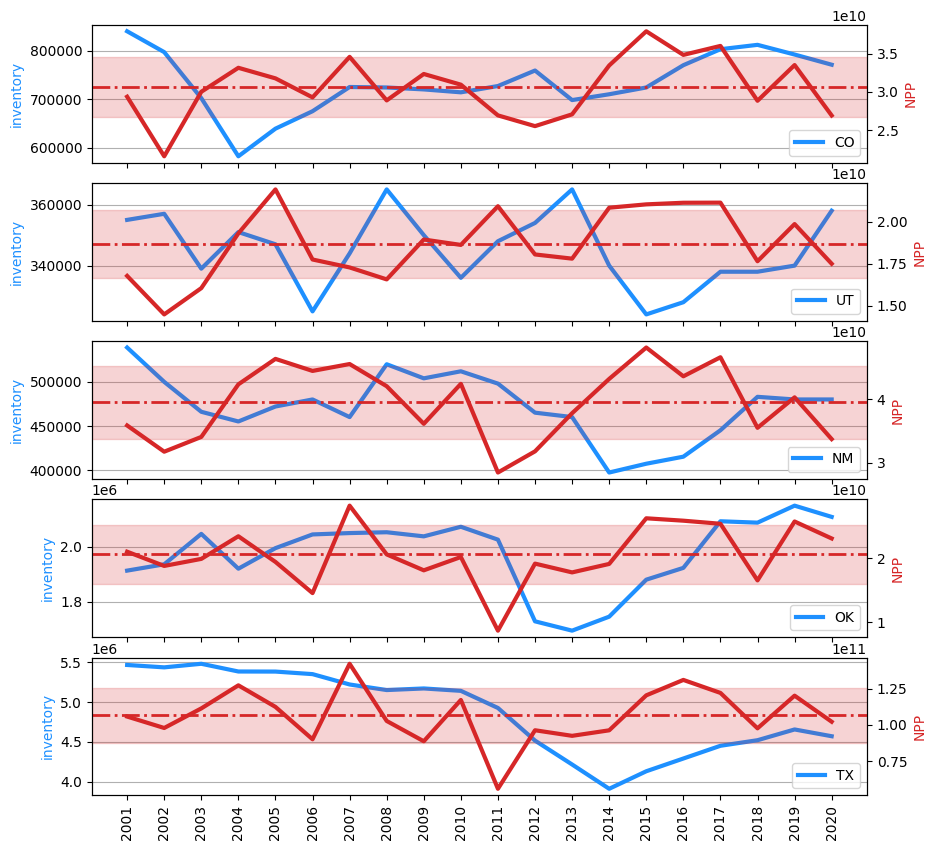

In [58]:
fig, axs = plt.subplots(5, 1, figsize=(10, 2*len(chosen_states)), sharex=True,
                        gridspec_kw={"hspace": 0.15, "wspace": 0.05})
axs[0].grid(axis="y", which="both")
axs[1].grid(axis="y", which="both")
axs[2].grid(axis="y", which="both")
axs[3].grid(axis="y", which="both")
axs[4].grid(axis="y", which="both")

ii=0
state_ = chosen_states[ii]
B = state_NPP_invent[state_NPP_invent.state==state_].copy()
color_ = "dodgerblue"
axs[ii].plot(B.year, B.inventory, c=color_, linewidth=3, label=state_);
axs[ii].set_ylabel('inventory', color=color_)

ax0T = axs[ii].twinx()  # instantiate a second axes that shares the same x-axis
color_ = 'tab:red'
ax0T.set_ylabel('NPP', color=color_)  # we already handled the x-label with ax1
ax0T.plot(B.year, B.state_rangeland_npp, c=color_, linewidth=3, label="NPP");

mu, std_ = B.state_rangeland_npp.mean(), statistics.stdev(B.state_rangeland_npp)
ax0T.axhline(y = mu, color =color_, linestyle = '-.', linewidth=2)
ax0T.axhspan(mu-std_, mu+std_, alpha=0.2, color="tab:red")

ax0T.tick_params(axis='y')
axs[ii].legend(loc="lower right");
####################################
ii = 1
state_ = chosen_states[ii]
B = state_NPP_invent[state_NPP_invent.state==state_].copy()
color_ = "dodgerblue"
axs[ii].plot(B.year, B.inventory, c=color_, linewidth=3, label=state_);
axs[ii].set_ylabel('inventory', color=color_)

ax0T = axs[ii].twinx()  # instantiate a second axes that shares the same x-axis
color_ = 'tab:red'
ax0T.set_ylabel('NPP', color=color_)  # we already handled the x-label with ax1
ax0T.plot(B.year, B.state_rangeland_npp, c=color_, linewidth=3, label="NPP");

mu, std_ = B.state_rangeland_npp.mean(), statistics.stdev(B.state_rangeland_npp)
ax0T.axhline(y = mu, color =color_, linestyle = '-.', linewidth=2)
ax0T.axhspan(mu-std_, mu+std_, alpha=0.2, color="tab:red")

ax0T.tick_params(axis='y')
axs[ii].legend(loc="lower right");
####################################
ii = 2
state_ = chosen_states[ii]
B = state_NPP_invent[state_NPP_invent.state==state_].copy()
color_ = "dodgerblue"
axs[ii].plot(B.year, B.inventory, c=color_, linewidth=3, label=state_);
axs[ii].set_ylabel('inventory', color=color_)

ax0T = axs[ii].twinx()  # instantiate a second axes that shares the same x-axis
color_ = 'tab:red'
ax0T.set_ylabel('NPP', color=color_)  # we already handled the x-label with ax1

mu, std_ = B.state_rangeland_npp.mean(), statistics.stdev(B.state_rangeland_npp)
ax0T.plot(B.year, B.state_rangeland_npp, c=color_, linewidth=3, label="NPP");
ax0T.axhline(y = mu , color =color_, linestyle = '-.', linewidth=2)

ax0T.axhspan(mu-std_, mu+std_, alpha=0.2, color="tab:red")

ax0T.tick_params(axis='y')
axs[ii].legend(loc="lower right");

####################################
ii = 3
state_ = chosen_states[ii]
B = state_NPP_invent[state_NPP_invent.state==state_].copy()
color_ = "dodgerblue"
axs[ii].plot(B.year, B.inventory, c=color_, linewidth=3, label=state_);
axs[ii].set_ylabel('inventory', color=color_)

ax0T = axs[ii].twinx()  # instantiate a second axes that shares the same x-axis
color_ = 'tab:red'
ax0T.set_ylabel('NPP', color=color_)  # we already handled the x-label with ax1

ax0T.plot(B.year, B.state_rangeland_npp, c=color_, linewidth=3, label="NPP");
mu = B.state_rangeland_npp.mean()
std_ = statistics.stdev(B.state_rangeland_npp)
ax0T.axhline(y = mu, color =color_, linestyle = '-.', linewidth=2)
ax0T.axhspan(mu-std_, mu+std_, alpha=0.2, color="tab:red")

ax0T.tick_params(axis='y')
axs[ii].legend(loc="lower right");
####################################
ii = 4
state_ = chosen_states[ii]
B = state_NPP_invent[state_NPP_invent.state==state_].copy()
color_ = "dodgerblue"
axs[ii].plot(B.year, B.inventory, c=color_, linewidth=3, label=state_);
axs[ii].set_ylabel('inventory', color=color_)

ax0T = axs[ii].twinx()  # instantiate a second axes that shares the same x-axis
color_ = 'tab:red'
ax0T.set_ylabel('NPP', color=color_)  # we already handled the x-label with ax1
ax0T.plot(B.year, B.state_rangeland_npp, c=color_, linewidth=3, label="NPP");
ax0T.tick_params(axis='y')
axs[ii].legend(loc="lower right");
mu = B.state_rangeland_npp.mean()
std_ = statistics.stdev(B.state_rangeland_npp)
ax0T.axhline(y = mu, color =color_, linestyle = '-.', linewidth=2)
ax0T.axhspan(mu-std_, mu+std_, alpha=0.2, color="tab:red")

axs[ii].set_xticks(B.year, B.year, rotation=90)


# axs[ii].xaxis.set_major_locator(mdates.YearLocator())
# axs[ii].xaxis.set_major_formatter(DateFormatter("%b"))
    
# axs.plot(["2015", "2016", "2017"], 
#          B[["2015", "2016", "2017"]].values[0], 
#          color = 'b', marker='o', markerfacecolor='r', markersize=5);

# odd_i = itertools.islice(B.columns[90:], 0, None, 3);
# odd_i = list(itertools.chain(odd_i));
# plt.xticks(odd_i, odd_i, rotation="vertical");

plt.tight_layout()
plots_dir = data_dir_base + "plots/"
fig_name = plots_dir + "inventoryDip_NPP.pdf"
plt.savefig(fname=fig_name, dpi=100, bbox_inches="tight")

In [38]:


v = B.state_rangeland_npp
vcentered = v - v.mean()
vcentered_norm = np.linalg.norm(vcentered)

print (f"{v.std()                          = }")
print (f"{statistics.stdev(v)              = }")
print (f"{vcentered_norm/np.sqrt(len(v)-1) = }")

print()
print (f"{np.std(v)                        = }")
print (f"{vcentered_norm/np.sqrt(len(v))   = }")

v.std()                          = 19013604074.907402
statistics.stdev(v)              = 19013604074.907406
vcentered_norm/np.sqrt(len(v)-1) = 19013604074.907406

np.std(v)                        = 18532168867.174416
vcentered_norm/np.sqrt(len(v))   = 18532168867.17442
